In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Core Libraries
import pandas as pd
import numpy as np
from scipy import stats
import random
import warnings

# Visualization Libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import squarify
%matplotlib inline

# Machine Learning Libraries
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.ensemble import IsolationForest
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, HistGradientBoostingClassifier

# Set random seed
rs = 42

# Ignore warnings
warnings.filterwarnings("ignore")

# Set color palette for Seaborn
colors= ['#1c76b6', '#a7dae9', '#eb6a20', '#f59d3d', '#677fa0', '#d6e4ed', '#f7e9e5']
sns.set_palette(colors)

In [ ]:
df_train = pd.read_csv("/kaggle/input/manga-sales-prediction-challenge/manga sales dataset/train.csv")
df_test = pd.read_csv("/kaggle/input/manga-sales-prediction-challenge/manga sales dataset/test.csv")

In [ ]:
df_train.head()

In [ ]:
print(f"There are {df_train.shape[1]} columns and {df_train.shape[0]} rows in the train dataset.")

In [ ]:
print("Column names and data type of each column:")
df_train.dtypes

In [ ]:
print("There are {} duplicates in the dataset.".format(df_train.duplicated().sum()))


In [ ]:
df_train = df_train.drop_duplicates()


In [ ]:
print("Checking for missing values in each column:")
print(df_train.isnull().sum())

In [ ]:
mode_year = df_train['Year_of_Release'].mode()[0]
df_train['Year_of_Release'] = df_train['Year_of_Release'].fillna(mode_year)

In [ ]:
# Convert Year_of_Release to Years_Since_Release
df_train['Years_Since_Release'] = 2024 - df_train['Year_of_Release']

# Drop the original Year_of_Release column if no longer needed
df_train.drop('Year_of_Release', axis=1, inplace=True)
df_test['Years_Since_Release'] = 2024 - df_test['Year_of_Release']
df_test.drop('Year_of_Release', axis=1, inplace=True)



In [ ]:
plt.figure(figsize=(18,12))
plt.title("Visualizing Missing Values")
sns.heatmap(df_train.isnull(), cbar=False, cmap=sns.color_palette(colors), yticklabels=False);

In [ ]:
# Save 'id' column for submission
test_ids = df_test['ID']

# Drop 'id' column in both datasets
df_train = df_train.drop(['ID'], axis=1)
df_test = df_test.drop(['ID'], axis=1)

# Define the target column
target_column = 'JP_Sales'

# Select categorical and numerical columns (initial)
categorical_columns = df_train.select_dtypes(include=['object']).columns
numerical_columns = df_train.select_dtypes(exclude=['object']).columns.drop(target_column)

# Print out column information
print("Target Column:", target_column)
print("\nCategorical Columns:", categorical_columns.tolist())
print("\nNumerical Columns:", numerical_columns.tolist())

In [ ]:
for column in categorical_columns:
    num_unique = df_train[column].nunique()
    print(f"'{column}' has {num_unique} unique categories.")

In [ ]:
# Print top 10 unique value counts for each categorical column
for column in categorical_columns:
    print(f"\nTop value counts in '{column}':\n{df_train[column].value_counts().head(10)}")

In [ ]:
print("The skewness of columns:")
print(df_train[numerical_columns].skew())

# Exploring our data


##  Distribution of Numerical Variables


In [ ]:
numerical_columns_to_plot = ['NA_Sales', 'EU_Sales', 'Other_Sales', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Years_Since_Release']

plt.figure(figsize=(12, 16)) 

for i, column in enumerate(numerical_columns_to_plot):
    plt.subplot(8, 1, i+1)
    sns.histplot(data=df_train, x=column, kde=False, bins=20, color=colors[0])
    plt.title(f'Distribution of {column}')
    sns.despine()

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

In [ ]:
# here am gonna try to remove some rows 
thresholds = {
    'NA_Sales': 1.5,       # Example: Remove rows where NA_Sales > 1.0
    'EU_Sales': 0.75,       # Example: Remove rows where EU_Sales > 1.0
    'Other_Sales': 0.5,    # Example: Remove rows where Other_Sales > 0.5
    'User_Score': 10,      # Example: Remove rows where User_Score > 10
    'User_Count': 200   ,  # Example: Remove rows where User_Count > 1000
    'Years_Since_Release':100
}

# Iterate through each column and threshold to filter data
for column, threshold in thresholds.items():
    df_train = df_train[df_train[column] <= threshold]

In [ ]:
numerical_columns_to_plot = ['NA_Sales', 'EU_Sales', 'Other_Sales', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Years_Since_Release']

plt.figure(figsize=(12, 16)) 

for i, column in enumerate(numerical_columns_to_plot):
    plt.subplot(8, 1, i+1)
    sns.histplot(data=df_train, x=column, kde=False, bins=20, color=colors[0])
    plt.title(f'Distribution of {column}')
    sns.despine()

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

## Distribution of Categorical Features


In [ ]:
for column in categorical_columns:
    
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df_train, x=column)
    plt.title(f'Countplot of {column}')
    
    plt.tight_layout()
    plt.show()

In [ ]:
X_train = df_train.drop('JP_Sales', axis=1)
y_train = df_train['JP_Sales']

# Redefine columns for preprocessing after feature engineering
numerical_columns = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_columns = X_train.select_dtypes(include=['object']).columns.tolist()

# Define preprocessing pipelines
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('convert_to_float32', FunctionTransformer(lambda x: x.astype(np.float32)))
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', OrdinalEncoder(dtype=np.int32, handle_unknown='use_encoded_value', unknown_value=-1))
])

# Combine the numerical and categorical pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_columns),
        ('cat', categorical_pipeline, categorical_columns)
    ]
)

# Apply the transformations to the training and test sets
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(df_test)

In [ ]:
from sklearn.ensemble import IsolationForest

# Print initial shape of the dataset
print("Initial shape of X_train_preprocessed:", X_train_preprocessed.shape)
print("Initial shape of y_train:", y_train.shape)

# Apply Isolation Forest for outlier detection
isolation_forest = IsolationForest(contamination=0.04, random_state=rs)

# Fit the model and predict outliers (-1 for outliers, 1 for inliers)
outlier_labels = isolation_forest.fit_predict(X_train_preprocessed)

# Print the distribution of outliers vs. inliers
print("Number of outliers detected:", (outlier_labels == -1).sum())
print("Number of inliers detected:", (outlier_labels == 1).sum())

# Filter out outliers from both X_train_preprocessed and y_train
non_outliers_mask = outlier_labels != -1

# Apply the mask to remove outliers
X_train_preprocessed_filtered = X_train_preprocessed[non_outliers_mask]
y_train_filtered = y_train[non_outliers_mask]

# Print final shape after removing outliers
print("Shape of X_train_preprocessed after removing outliers:", X_train_preprocessed_filtered.shape)
print("Shape of y_train after removing outliers:", y_train_filtered.shape)


In [91]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso, Ridge, LinearRegression
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# List of models to try
models = [
    ('RandomForest', RandomForestRegressor(n_estimators=100, random_state=rs)),
    ('GradientBoosting', GradientBoostingRegressor(n_estimators=100, random_state=rs)),
    ('Lasso', Lasso(random_state=rs)),
    ('Ridge', Ridge(random_state=rs)),
    ('LinearRegression', LinearRegression()),
    ('XGBoost', xgb.XGBRegressor(n_estimators=100, random_state=rs)),
    ('CatBoost', cb.CatBoostRegressor(n_estimators=100, random_state=rs, verbose=0)),
    ('LightGBM', lgb.LGBMRegressor(n_estimators=100, random_state=rs)),
    ('ElasticNet', ElasticNet(random_state=rs)),
    ('SVR', SVR()),
    ('KNeighbors', KNeighborsRegressor())
]

# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=rs)  # 5-Fold Cross Validation

# Define MAE as the scoring metric
mae_scorer = make_scorer(mean_absolute_error)

# Loop through each model
for name, model in models:
    # Apply cross-validation for each model
    mae_scores = cross_val_score(model, X_train_preprocessed_filtered, y_train_filtered, cv=kf, scoring=mae_scorer)
    
    # Print the results for each model
    print(f"Model: {name}")
    print(f"MAE scores for each fold: {mae_scores}")
    print(f"Mean MAE: {np.mean(mae_scores)}")
    print(f"Standard Deviation of MAE: {np.std(mae_scores)}")
    print("-" * 50)


Model: RandomForest
MAE scores for each fold: [0.0435446  0.04556226 0.03919039 0.04031134 0.04225619]
Mean MAE: 0.04217295626956198
Standard Deviation of MAE: 0.0022687891966568182
--------------------------------------------------
Model: GradientBoosting
MAE scores for each fold: [0.04538452 0.04475048 0.03981927 0.03990223 0.04228281]
Mean MAE: 0.042427863316512444
Standard Deviation of MAE: 0.0023384174574501812
--------------------------------------------------
Model: Lasso
MAE scores for each fold: [0.05364806 0.05616726 0.05002566 0.05310512 0.05238228]
Mean MAE: 0.053065678042191845
Standard Deviation of MAE: 0.001983395565727636
--------------------------------------------------
Model: Ridge
MAE scores for each fold: [0.05220181 0.05603534 0.04967057 0.05053533 0.04823375]
Mean MAE: 0.05133536160044348
Standard Deviation of MAE: 0.0026785089365300545
--------------------------------------------------
Model: LinearRegression
MAE scores for each fold: [0.05220368 0.05603754 0.04

## stacking models 

In [ ]:
# Import necessary libraries
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
import numpy as np

# Define hyperparameter grids for the models
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20,],
    'min_samples_split': [ 5, 10]
}

param_grid_xgb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1,],
    'max_depth': [3, 6,]
}

param_grid_catboost = {
    'iterations': [100, 200],
    'depth': [6, 10],
    'learning_rate': [0.01, 0.1]
}

param_grid_gb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5,]
}

# Create base models with hyperparameter tuning using GridSearchCV
rf_model = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=5, scoring='neg_mean_absolute_error')
xgb_model = GridSearchCV(XGBRegressor(random_state=42), param_grid_xgb, cv=5, scoring='neg_mean_absolute_error')
catboost_model = GridSearchCV(CatBoostRegressor(random_state=42, verbose=0), param_grid_catboost, cv=5, scoring='neg_mean_absolute_error')
gb_model = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid_gb, cv=5, scoring='neg_mean_absolute_error')

# Define the meta-model (stacking model) without hyperparameter tuning
meta_model = LinearRegression()

# Initialize the StackingRegressor with the grid-searched base models
stacked_model = StackingRegressor(
    estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model),
        ('catboost', catboost_model),
        ('gb', gb_model)
    ],
    final_estimator=meta_model
)


# Step 1: Train the stacked model using cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_scores = cross_val_score(stacked_model, X_train_preprocessed_filtered, y_train_filtered, cv=kf, scoring='neg_mean_absolute_error')

# Convert negative MAE to positive
mae_scores = -mae_scores

# Step 2: Print cross-validation results
print(f"MAE scores for each fold: {mae_scores}")
print(f"Mean MAE: {np.mean(mae_scores)}")
print(f"Standard Deviation of MAE: {np.std(mae_scores)}")


In [94]:
stacked_model.fit(X_train_preprocessed_filtered,y_train_filtered)
test_preds = stacked_model.predict(X_test_preprocessed)


In [98]:
# Create a DataFrame to hold the submission results
output = pd.DataFrame({'ID': test_ids,
                       'JP_Sales': test_preds})

# Save the output DataFrame to a CSV file
output.to_csv('submission2.csv', index=False)

output.head()

,ID,JP_Sales
0,Manga_04953,0.027374
1,Manga_09628,-0.004638
2,Manga_08116,0.043407
3,Manga_01517,0.012597
4,Manga_08868,0.031800


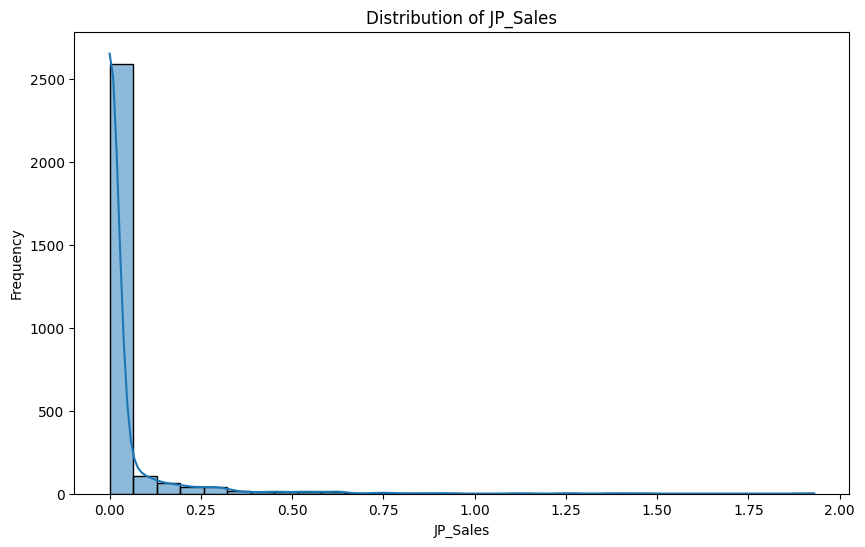

KeyError: 'JP_Sales'

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
column_names = X_train.columns

X_train_preprocessed_filtered_df = pd.DataFrame(X_train_preprocessed_filtered, columns=column_names)  # column_names should be the list of column names


# Plot the distribution of JP_Sales
plt.figure(figsize=(10, 6))
sns.histplot(y_train_filtered, bins=30, kde=True)
plt.title('Distribution of JP_Sales')
plt.xlabel('JP_Sales')
plt.ylabel('Frequency')
plt.show()

# Calculate basic statistics for JP_Sales
jp_sales_stats = X_train_preprocessed_filtered_df['JP_Sales'].describe()
print("Basic Statistics of JP_Sales:")
print(jp_sales_stats)

# Calculate the mean and median specifically
mean_jp_sales = X_train_preprocessed_filtered_df['JP_Sales'].mean()
median_jp_sales = X_train_preprocessed_filtered_df['JP_Sales'].median()

print(f"Mean JP_Sales: {mean_jp_sales}")
print(f"Median JP_Sales: {median_jp_sales}")



# 